In [ ]:
! pip3 install gym

In [ ]:
%matplotlib inline

In [ ]:
import tensorflow as tf


In [ ]:
t = 0
data['acs'][0][0]

In [ ]:
!pip3 install mujoco_py

In [ ]:
import numpy as np
data = np.load('deterministic.trpo.Hopper.0.00.npz')

In [ ]:
env.reset()

for t in range(100):
    
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    env.render()
    if done:
        break
env.close()

In [ ]:
print(data['obs'].shape)

In [ ]:
for i_episode in range(20):
    observation = env.reset()
    episode = np.random.choice(data['acs'].shape[0])
    for t in range(1000):
        env.render()
        action = data['acs'][episode][t]
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

In [ ]:
def mujoco_generator(mujoco_dataset):
    for item in zip(*[mujoco_dataset[key] for key in mujoco_dataset.files]):
        yield {key:value for key,value in zip( mujoco_dataset.files,item)}

In [ ]:
mujuco_hopper_tf = tf.data.Dataset.from_generator(
    generator = lambda: (row for row in mujoco_generator(mujoco_hopper_np)),
    output_types={k: tf.float32 for k in next(mujoco_generator(mujoco_hopper_np)).keys()},
    output_shapes={k: v.shape for k, v in next(mujoco_generator(mujoco_hopper_np)).items()}
)

In [1]:
import gym
env = gym.make('Hopper-v2')

In [2]:
from __future__ import absolute_import, division, \
    print_function, unicode_literals

import tensorflow as tf
import numpy as np

mujoco_hopper_np = np.load('deterministic.trpo.Hopper.0.00.npz')
#mujuco_hopper_tf = tf.data.Dataset.from_generator()

In [19]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions

class ActorCritic(tf.keras.Model):
    
    def __init__(self, name='actor_critic', dim_actions=3, num_layers=2, input_shape=(11)
                 , num_units=100, **kwargs):
        super().__init__(name=name, **kwargs)
        self._num_layers = num_layers
        self._num_units = num_units
        self._dim_actions = dim_actions
        self._layers = list()
        for n, l in enumerate(range(self._num_layers)):

            self._layers.append(tf.keras.layers.Dense(
                                          self._num_units,
                                          activation=tf.nn.relu))
            if n == 0:
                self._layers[-1].build(input_shape)
            else:
                self._layers[-1].build((num_units))
        self._value_output = tf.keras.layers.Dense(
                                            1,
                                          activation=None)
        self._value_output.build((num_units))
        self._action_output = tf.keras.layers.Dense(
                                            self._dim_actions,
                                          activation=tf.nn.tanh)
        self._action_output.build((num_units))
        self._action_dist_std = tf.Variable([1., 1, 1], trainable=True)
        self._action_dist =  None
        

    def get_params(self):
        weights = []
        for layer in self.layers:
            weights += layer.trainable_weights
        return weights+\
            self._action_output.trainable_weights + \
            self._value_output.trainable_weights + \
            [self._action_dist_std]
        
    
    def call(self, inputs):
        x = self._layers[0](inputs)
        for layer in self._layers[1:self._num_layers]:
            x = layer(x)
        #self._action_dist = tfd.Normal(self._action_output(x)
        #                               , tf.exp(self._action_dist_std))
        return -1*tf.math.log(tf.sigmoid(self._value_output(x)))
        #return self._value_output(x)
    
    def log_prob(self, x):
        return self._action_dist.log_prob(x)
    
    def sample(self, inputs, output='action'):
        x = self._layers[0](inputs)
        for layer in self._layers[1:self._num_layers]:
            x = layer(x)
        self._action_dist = tfd.Normal(self._action_output(x),
                                       tf.exp(self._action_dist_std))
        
        if output == 'action':
            return self._action_dist.sample()
        elif output == 'entropy':
            return tf.reduce_mean(self._action_dist.entropy())
        else:
            raise ValueError("unknown sample type: {}".format(output))



        

In [65]:
import copy

class PPO(tf.keras.Model):
    
    def __init__(self, name='ppo', dim_actions=3, num_layers=2, num_units=100, 
                 eps=0.2, v_coeff=0.5, ent_coeff=0.01, lr=3e-4, **kwargs):
        super().__init__(name=name, *kwargs)
        self._dim_actions = dim_actions
        self._num_layers = num_layers
        self._num_units = num_units
        self._eps = eps
        self._v_coeff = v_coeff
        self._ent_coeff = ent_coeff
        self._policy = ActorCritic(num_layers=self._num_layers, num_units=self._num_units,
                                        dim_actions=self._dim_actions)
        self._new_policy = ActorCritic(num_layers=self._num_layers, num_units=self._num_units,
                                        dim_actions=self._dim_actions)
        self._optimizer = tf.keras.optimizers.Adam(lr)
    
    def loss(self, actions, observations, advantages, returns):
        ratio = tf.exp(self._policy.log_prob(actions) - 
                       self._new_policy.log_prob(actions))
        surr = ratio * advantages
        actor_loss = tf.reduce_mean(
                tf.minimum(surr, tf.clip_by_value(ratio, 1 - self._eps, 1 + self._eps) * advantages))
        critic_loss = tf.reduce_mean(tf.square(returns - self._new_policy.call(observations)))
        return -1*actor_loss - self._ent_coeff * tf.reduce_mean(self._new_policy.sample(observations, 'entropy')) \
                         + self._v_coeff * critic_loss
    
    def train_policy(self, actions, observations, advantages, returns):
        params = self._new_policy.get_params()
        with tf.GradientTape(watch_accessed_variables=False) as g:
            g.watch(params)
            cost = self.loss(actions, observations, advantages, returns)
            
        grads = g.gradient(cost, params)
        grads = [grad if grad is not None else tf.zeros_like(var)
              for var, grad in zip(params, grads)]
        self._optimizer.apply_gradients(zip(grads, params),
            experimental_aggregate_gradients=False)
    
    def update_policy(self):
        self._policy = copy.deepcopy(self._new_policy)
        
    def get_action(self, x):
        return self._new_policy.sample(x, output='action')
    
    def get_value(self, x):
        return self._new_policy.call(x)
            

In [66]:
def ppo_iteration(mini_batch_size, observations, actions, returns, advantages):
    batch_size = observations.shape[0]
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield (observations[rand_ids, :], actions[rand_ids, :],
               returns[rand_ids, :], advantages[rand_ids, :])


In [67]:
class Discriminator(tf.keras.Model):
    
    def __init__(self, name='discriminator', dim_actions=3, num_layers=2, num_units=100, lr=3e-4, **kwargs):
        super().__init__(name=name, **kwargs)
        self._dim_actions = dim_actions
        self._num_layers = num_layers
        self._num_units = num_units
        self._layers = list()
        for l in range(self._num_layers):
            self._layers.append(tf.keras.layers.Dense(
                                          self._num_units,
                                          activation=tf.nn.tanh))
        self._layers.append(tf.keras.layers.Dense(
                                          1,
                                          activation=None))
        self._optimizer = tf.keras.optimizers.Adam(lr)
        
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x
        
    def get_params(self):
        weights = []
        for layer in self.layers:
            weights += layer.trainable_weights
        return weights
    
    def get_reward(self, x):
        return -1*tf.squeeze(tf.math.log(tf.sigmoid(self.call(x))))
    
    def loss(self, x):
        expert_out, policy_out = tf.split(self.call(x), num_or_size_splits=2, axis=0)
        return (tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(policy_out), policy_out)
                     + tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(expert_out), expert_out))
    
    def train_discriminator(self, x):
        params = self.get_params()
        with tf.GradientTape(watch_accessed_variables=False) as g:
            g.watch(params)
            cost = self.loss(x)
        grads = g.gradient(cost, params)
        grads = [grad if grad is not None else tf.zeros_like(var)
              for var, grad in zip(params, grads)]
        self._optimizer.apply_gradients(zip(grads, params),
            experimental_aggregate_gradients=False)

In [68]:

def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [69]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(model, vis=False):
    ob = env.reset()
    ob = tf.reshape(tf.convert_to_tensor(ob), (1,11))
    done = False
    total_reward = 0
    while not done:
        if vis:
            env.render()
        ac = model.get_action(ob)[0]
        #print(ac)
        ac = tf.reshape(tf.convert_to_tensor(ac), (1, 3))
        next_ob, reward, done, _ = env.step(ac)
        #print(reward)
        ob = next_ob
        ob = tf.reshape(tf.convert_to_tensor(ob), (1,11))
        total_reward += reward
    return total_reward

In [70]:
ppo_hidden_size           = 256
discriminator_hidden_size = 256
lr                        = 3e-4
num_steps                 = 200
mini_batch_size           = 5
ppo_epochs                = 5
threshold_reward          = -200

max_frames = 100000000
frame_idx  = 0
test_rewards = []

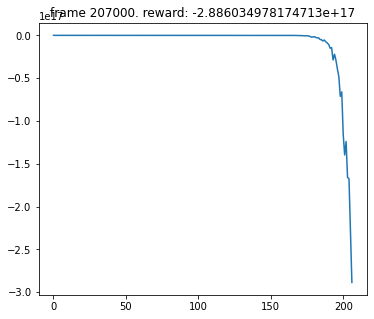

MujocoException: Unknown warning type Time = 2.7680.Check for NaN in simulation.

In [71]:
import numpy as np
ob_shape = list(env.observation_space.shape)
ac_shape = list(env.action_space.shape)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)


ob = env.reset()
early_stop = False


ppo = PPO()

discriminator = Discriminator()


i_update = 0
state = env.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:
    i_update += 1
    
    values    = []
    obs    = []
    acs   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        ob = tf.reshape(tf.convert_to_tensor(ob), (1,11))
        ac = ppo.get_action(ob)
        ac = tf.reshape(tf.convert_to_tensor(ac), (1, 3))
        next_ob, _, done, _ = env.step(ac)
        #print(np.concatenate([ob, ac],axis=1))
        reward = discriminator.get_reward(np.concatenate([ob, ac], axis=1))
        #print(reward)
        value = ppo.get_value(ob)
        values.append(value)
        rewards.append(reward)
        masks.append((1-done))

        obs.append(ob)
        acs.append(ac)

        ob = next_ob
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env(ppo) for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            
    next_ob = tf.reshape(tf.convert_to_tensor(next_ob), (1,11))
    next_value = ppo.get_value(next_ob)
    returns = compute_gae(next_value, rewards, masks, values)

    returns = np.concatenate(returns)
    values = np.concatenate(values)
    obs = np.concatenate(obs)
    acs = np.concatenate(acs)
    advantages = returns - values
    
    # Policy Update
    if i_update % 3 == 0:
        ppo.update_policy()
        for _ in range(ppo_epochs):
            for ob_batch, ac_batch, return_batch, adv_batch in ppo_iteration(mini_batch_size, obs, acs, returns, advantages):
                ppo.train_policy(ac_batch, ob_batch, adv_batch, return_batch)
    
    # Discriminator Update
    expert_samples = np.random.randint(0, mujoco_hopper_np['acs'].shape[0], 1)
    expert_ob_ac = np.concatenate([
        mujoco_hopper_np['obs'][expert_samples,:num_steps,:].reshape(num_steps,11),
        mujoco_hopper_np['acs'][expert_samples,:num_steps,:].reshape(num_steps,3)
    ],1)
    policy_ob_ac = np.concatenate([obs, acs], 1)
    discriminator.train_discriminator(np.concatenate([expert_ob_ac, policy_ob_ac], axis=0))

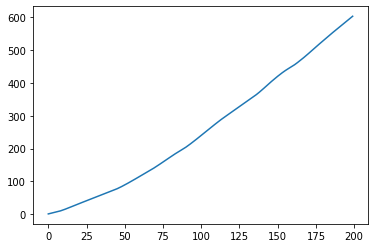

In [60]:
plt.plot(mujoco_hopper_np['rews'][0][:200].cumsum())

In [61]:
obs.shape

(200, 11)

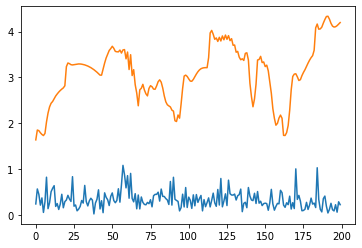

In [62]:
plt.plot(discriminator.get_reward(policy_ob_ac))
plt.plot(discriminator.get_reward(expert_ob_ac))

In [63]:
advantages

array([[-0.07719508],
       [-0.06276992],
       [ 0.16823724],
       [ 0.24616736],
       [ 0.1724616 ],
       [ 0.04458052],
       [ 0.01678818],
       [ 0.07430884],
       [ 0.2199094 ],
       [ 0.26988813],
       [ 0.2571216 ],
       [-0.10630035],
       [ 0.3709961 ],
       [-0.04497701],
       [ 0.15200442],
       [ 0.35746527],
       [ 0.17116159],
       [ 0.24363649],
       [-0.05938667],
       [ 0.19457775],
       [ 0.06045669],
       [ 0.181956  ],
       [ 0.04385154],
       [-0.08749534],
       [-0.12686618],
       [ 0.02549478],
       [ 0.01337613],
       [ 0.17769538],
       [ 0.3823432 ],
       [-0.05618531],
       [ 0.2524083 ],
       [-0.19374049],
       [-0.04585779],
       [ 0.06770211],
       [-0.03582539],
       [ 0.19008487],
       [-0.20278817],
       [-0.11420465],
       [-0.14233178],
       [-0.07062373],
       [-0.03582317],
       [-0.0658903 ],
       [-0.11182524],
       [-0.13923563],
       [-0.25619856],
       [-0

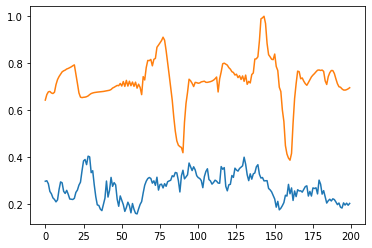

In [64]:
plt.plot(ppo.get_value(policy_ob_ac[:,:11]))
plt.plot(ppo.get_value(expert_ob_ac[:,:11]))

In [51]:
#print(expert_ob_ac[:,-3:])
print(policy_ob_ac[:,-3:])

[[-7.26463928e+01 -2.11990976e+00  4.25127220e+01]
 [-2.50913124e+01 -3.64758492e+00 -8.00242615e+01]
 [-9.46033096e+01  1.81557140e+01  9.44270020e+01]
 [-1.16452255e+02 -1.16896286e+02 -7.81799469e+01]
 [-5.92543650e+00 -1.30328751e+01 -4.04797173e+01]
 [ 4.02776947e+01  6.78007355e+01  8.92932053e+01]
 [-2.24944191e+01 -5.36942291e+01 -2.22126446e+01]
 [ 1.45491199e+01 -8.27702904e+00 -4.51836662e+01]
 [-6.18021584e+01 -2.22433543e+00  2.16035213e+01]
 [-6.36205559e+01 -3.45204887e+01 -7.89846373e+00]
 [ 1.47325172e+01  5.87685013e+01  1.54600113e+02]
 [ 1.27417542e+02 -3.51212120e+01 -6.48387222e+01]
 [-7.80836563e+01  1.07959900e+01  2.77368145e+01]
 [ 2.32087269e+01  3.28159447e+01  8.83043900e+01]
 [ 5.98764801e+01 -2.09589214e+01  7.32945557e+01]
 [ 1.28589752e+02 -7.94111786e+01 -5.84062271e+01]
 [ 3.66608763e+00  4.03965988e+01 -1.20064339e+02]
 [-1.35796326e+02 -9.41295395e+01  7.76071014e+01]
 [-2.55125122e+01  2.22961254e+01  8.86086960e+01]
 [-5.49191666e+00 -6.10284500e+

In [52]:
test_env(ppo)

-118.11516805320683

In [32]:
mujoco_hopper_np['acs'][0]

array([[ 2.0597913 ,  1.3272896 ,  1.1536376 ],
       [ 1.5374647 ,  1.5265774 ,  1.1468849 ],
       [ 1.7895619 ,  1.5771883 ,  0.9346594 ],
       ...,
       [ 1.4261599 ,  0.29850006,  1.4366484 ],
       [-1.2441537 ,  0.34274337,  1.9380379 ],
       [ 1.4767873 ,  0.04210341,  0.49480468]], dtype=float32)

In [ ]:
mujoco_hopper_np['rews'][0][:25].sum()

In [ ]:
plt.plot(mujoco_hopper_np['rews'][0][:25])

In [ ]:
env.step([1,  1, 1])

In [ ]:
-1*np.log(0.001)